In [2]:
import numpy as np
import matplotlib.pyplot as plt

from math import ceil, floor
from scipy.optimize import minimize
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver



100%|██████████| 1000/1000 [00:04<00:00, 201.50it/s]


(array([21., 14., 25., 13., 21., 27., 33., 27., 44., 40., 52., 58., 60.,
        59., 60., 63., 63., 44., 39., 32.]),
 array([  0.69460064,  14.57729625,  28.45999185,  42.34268745,
         56.22538305,  70.10807865,  83.99077426,  97.87346986,
        111.75616546, 125.63886106, 139.52155667, 153.40425227,
        167.28694787, 181.16964347, 195.05233908, 208.93503468,
        222.81773028, 236.70042588, 250.58312148, 264.46581709,
        278.34851269]),
 <BarContainer object of 20 artists>)

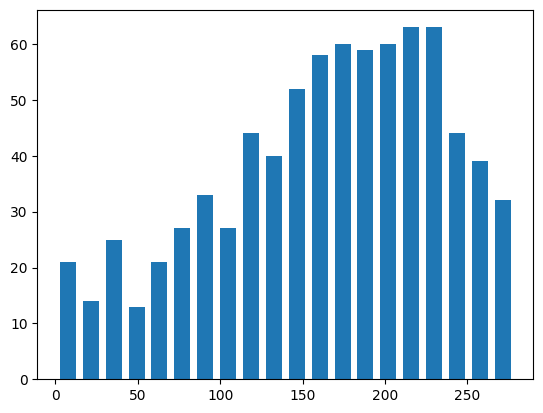

In [32]:
lens_model_list = ['SIE']

# generate list of coordinates #
def generate_random_coordinates(num_points, x_bound, y_bound):
    x_coords = np.random.uniform(x_bound[0], x_bound[1], num_points)
    y_coords = np.random.uniform(y_bound[0], y_bound[1], num_points)
    return x_coords, y_coords

# generate beta population in arcsec
num_points = 1000
len_coord_arcsec = (0, 0)
x_bound = (len_coord_arcsec[0] - 1 , len_coord_arcsec[0] + 1) 
y_bound = (len_coord_arcsec[1] - 1, len_coord_arcsec[1] + 1)  
betax, betay = generate_random_coordinates(num_points, x_bound, y_bound)
# define parameter values of lens models #
kwargs_sie = {'theta_E': 1.0, 'e1':0, 'e2':0.2, 'center_x': 0, 'center_y': 0}
kwargs_lens = [kwargs_sie]
lensModel = LensModel(lens_model_list=lens_model_list, z_source=1.0, z_lens=0.5)
solver = LensEquationSolver(lensModel)
dt_analytical = []
dt_value = []
for i in tqdm(range(len(betax))):
    thetax, thetay = solver.image_position_from_source(betax[i], betay[i], kwargs_lens=kwargs_lens)
    t_analytical = lensModel.arrival_time(thetax , thetay , kwargs_lens, x_source=betax[i], y_source=betay[i])
    if len(t_analytical) == 0:
        continue
    min_t = min(t_analytical)
    t_analytical = [t - min_t for t in t_analytical if t - min_t != 0]
    dt_analytical.append(t_analytical)
dt_pop_hist = np.concatenate(dt_analytical)
plt.hist(dt_pop_hist, bins=20 ,rwidth=0.7)



In [30]:

print(betay[0:100])

[ 0.47079921  0.27341734 -0.32334071 -0.24666179  0.31355178  0.66422494
  0.40358476  0.56790037 -0.07427052 -0.65560754 -0.11410689 -0.62196131
  0.64035536  0.82492648  0.10085923  0.38327443 -0.63983787  0.48767915
 -0.31244202 -0.3129005   0.72290925 -0.69025765 -0.40000549 -0.55651805
 -0.86836483  0.83542596  0.15791535  0.91375716 -0.86793945 -0.62270206
 -0.41348158  0.53944727 -0.49597359  0.08026057 -0.97290303 -0.88736561
  0.7890276   0.11985526  0.69646927  0.64502601  0.40835006  0.66246783
 -0.42315665 -0.30946235  0.69498287 -0.87054172  0.93551105 -0.35049521
  0.71976287  0.48368978  0.79795066 -0.23708325  0.29123285 -0.4192666
 -0.45552608  0.33081652 -0.52923813 -0.91102441  0.83782916  0.41844934
  0.81325131  0.4926076   0.45360307  0.41896231 -0.86390627  0.31612628
 -0.7130064  -0.50268067 -0.11092586 -0.41753932  0.82519502 -0.48399427
 -0.88983839  0.75419624 -0.21261776 -0.61024912 -0.92258658 -0.22081305
 -0.68793357  0.32380091 -0.25090775  0.79220753  0.